In [2]:
import numpy as np
from dobbel import dobbellogger
from help_functies import *
from calibrator3 import calibrate
import matplotlib.pyplot as plt
dob = dobbellogger()

In [ ]:
q_rot = np.array([0.23289724, 0.6497377, 0.66263071, -0.2907238])
cali = calibrate(dob, 10, 1, 400, 2, 125, q_rot)
acc_std = cali['acc std']
gyro_std = cali['gyro std']
print(cali)

Leg de dobbelsteen met nummer  1  boven
Wacht 1 secondes
Logging data for 10s


In [3]:
cali = {'gyro bias': np.array([ 0.5007456 , -0.113276  ,  0.01238024]), 'gyro std': np.array([0.08902153, 0.09786986, 0.11230942]), 'acc values': np.array([ 0.99164924, -1.00316003,  1.00062089, -0.99832454,  1.01896869, -1.00376521]), 'acc std': np.array([0.00355673, 0.00311978, 0.00605471])}
q_rot = np.array([0.23289724, 0.6497377, 0.66263071, -0.2907238])
acc_std = cali['acc std']
gyro_std = cali['gyro std']

In [45]:
dob.connect()
dob.log(5, 100, 4, 2000)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [46]:
# Deze code niet vaker dan 1 keer uitvoeren!
data = remove_nan(data)
data = rotate_data(data, q_rot)
data = remove_bias(data, cali)

In [47]:
data.head(2000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,-0.997902,0.028777,0.091456,-0.260577,0.154265,-0.074393
1,10.0,-1.007615,0.032179,0.089338,-0.005816,-0.242618,0.110336
2,20.0,-1.004342,0.029886,0.089183,-0.010235,-0.067929,0.028822
3,31.0,-1.006442,0.031012,0.090326,-0.011775,0.062512,-0.010837
4,39.0,-1.006162,0.031469,0.089201,-0.008402,0.096070,0.024406
...,...,...,...,...,...,...,...
505,4887.0,-1.003878,0.028423,0.092019,-0.066306,0.050201,-0.002336
506,4888.0,-1.003947,0.028462,0.091923,-0.072537,0.063327,-0.005798
507,4897.0,-1.004568,0.028805,0.091057,-0.072537,0.063327,-0.005798
508,4907.0,-1.002846,0.029211,0.091013,-0.006019,-0.025982,0.072875


In [48]:
for column in data.columns:
    print(column, np.mean(data[column]))

timestamp 2460.7372549019606
x_acc -1.0051623208451717
y_acc 0.02957110657489731
z_acc 0.09066652253768673
x_gyro -0.0015549813687767422
y_gyro 0.00792934805729111
z_gyro 0.007190104781755203


In [49]:
y11 = np.array([np.mean(data['x_acc'][0:10]), np.mean(data['y_acc'][0:10]), np.mean(data['z_acc'][0:10])])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
ymb= np.array([1, 2, 3])
mb = np.cross(gb, np.cross(ymb / np.linalg.norm(ymb), gb))

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) #- np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]
q11 = max_eigenvector

In [50]:
q11 = max_eigenvector

dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11 = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))
v1 = np.array([0,0,0])
p1 = np.array([0,0,0])

In [51]:
qtmin1tmin1 = np.reshape(q11, 4)
Ptmin1tmin1 = P11
vtmin1 = v1
ptmin1 = p1

q_list = [qtmin1tmin1]
v_list = [vtmin1]
p_list = [ptmin1]


Q = np.array([
    [gyro_std[0] ** 2, 0, 0],
    [0, gyro_std[1] ** 2, 0],
    [0, 0, gyro_std[2] ** 2]
])

R = np.array([
    [acc_std[0] ** 2, 0, 0],
    [0, acc_std[1] ** 2, 0],
    [0, 0, acc_std[2] ** 2],
])

epsilon_list = []
an_list = []
yat_list = []

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)

    Ftmin1 = right_quat_mul(expq_omega)
    Gtmin1 = - 0.5 * dt * np.matmul(left_quat_mul(qtmin1tmin1), dqde)
    Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)
    qttmin1 = quat_mul(qtmin1tmin1, expq_omega)
    
    q0, q1, q2, q3 = qttmin1
    H = 2 * np.array([
        [-q2, q3, -q0, q1],
        [q1, q0, q3, q2],
        [2 * q0, 0, 0, 2 * q3]
    ])

    S = np.matmul(np.matmul(H, Pttmin1), H.T) + R
    K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))

    yat = np.array([data['x_acc'][i], data['y_acc'][i], data['z_acc'][i]])
    yat_list.append(yat)
    yattmin1 = rotate_vector(gn, quaternion_conjugate(qttmin1))
    yateps = yat / np.linalg.norm(yat)
    epsilon = yateps - yattmin1
    q_tt_measure = np.reshape(qttmin1, (4, 1)) + np.matmul(K, np.reshape(epsilon, (3, 1)))
    Ptt = Pttmin1 - np.matmul(np.matmul(K, H), Pttmin1)
    qtt = q_tt_measure / ((np.linalg.norm(q_tt_measure)))
    
    an = rotate_vector(yat, np.reshape(qtt, 4)) - gn
    print(an, yat)
    an = an * 9.81
    an_list.append(an)
    vt = vtmin1 + dt * an
    pt = ptmin1 + dt * vtmin1 + 0.5 * an * dt ** 2 

    Ptmin1tmin1 = Ptt
    qtmin1tmin1 = np.reshape(qtt, 4)
    ptmin1 = pt
    vtmin1 = vt

    q_list.append(qtmin1tmin1)
    epsilon_list.append(epsilon)
    p_list.append(ptmin1)
    v_list.append(vtmin1)

[-3.14151497e-07 -1.98524718e-07  1.20790292e-02] [-1.00761456  0.03217932  0.08933838]
[-2.45900420e-05  1.03661750e-03  8.73644153e-03] [-1.00434235  0.02988624  0.08918257]
[-6.50793603e-04  1.17862433e-05  1.09625403e-02] [-1.00644184  0.03101248  0.09032569]
[ 0.00030169 -0.00033695  0.01059811] [-1.0061618   0.03146915  0.08920129]
[-1.98647511e-04  5.45465572e-06  1.08178551e-02] [-1.00634029  0.03115841  0.08978391]
[-0.00218378  0.00114521  0.01180848] [-1.00714348  0.02976008  0.0924057 ]
[-0.00279751 -0.00020086  0.00878227] [-1.00397915  0.03115684  0.09329866]
[-0.00216925  0.00241048  0.01031575] [-1.00561254  0.02763647  0.09342419]
[-0.00068968  0.00104702  0.00848506] [-1.0038921   0.02842808  0.09184869]
[-0.00052601 -0.00023237  0.00838382] [-1.0037629   0.02981223  0.09170346]
[-0.00109807 -0.00040896  0.00925243] [-1.00454583  0.03023454  0.09254939]
[ 0.00017629 -0.00083101  0.00864347] [-1.0040392   0.03095383  0.09115649]
[ 0.00154699 -0.00126548  0.00974939] [-

In [52]:
ans = np.reshape(np.concatenate(an_list), (int(len(an_list)), 3))
for i in range(3):
    print(np.mean(ans[:,i]))

-0.0001996555518916999
9.152003730223555e-05
0.09507610954026925


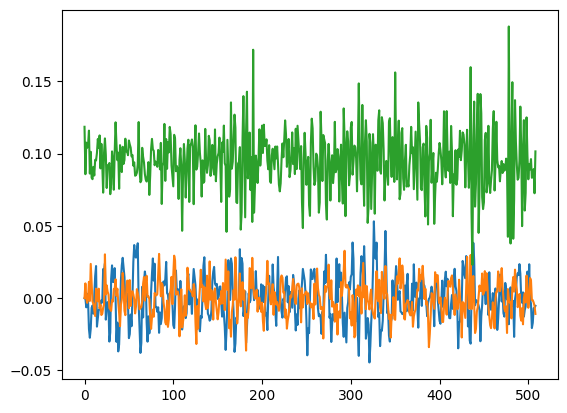

In [53]:
plt.plot(ans[:,0])
plt.plot(ans[:,1])
plt.plot(ans[:,2])
plt.show()

In [54]:
yats = np.reshape(np.concatenate(yat_list), (int(len(yat_list)), 3))
for i in range(3):
    print(np.mean(yats[:,i]))

-1.0051765841226652
0.029572665830571967
0.09066497183402997


In [55]:
print(np.linalg.norm(np.mean(yats, axis=0)))

1.0096903708318217


In [56]:
plot_x = []
plot_y = []
plot_z = []

for q, timestamp in zip(q_list, data['timestamp']):
    euler = quaternion_to_euler(q) * 180 / np.pi
    plot_x.append(euler[0])
    plot_y.append(euler[1])
    plot_z.append(euler[2])

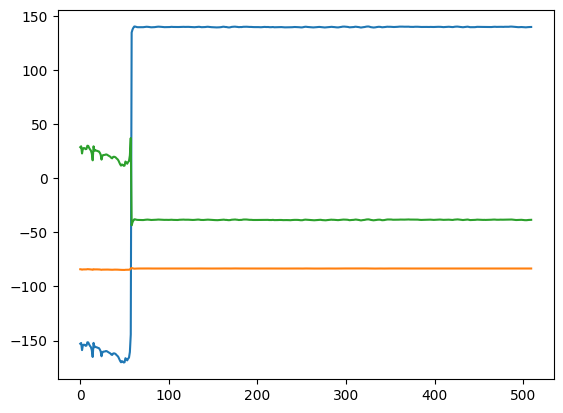

In [57]:
plt.plot(plot_x)
plt.plot(plot_y)
plt.plot(plot_z)

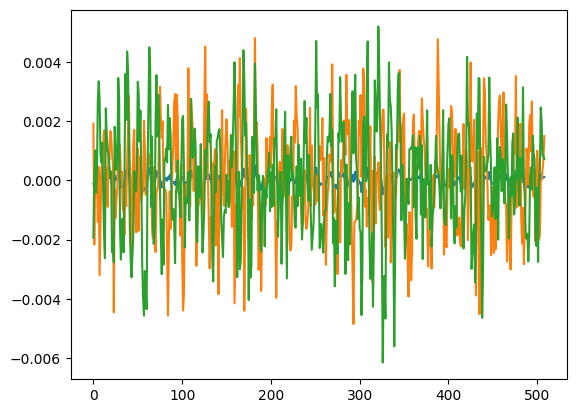

In [58]:
epsilons = np.concatenate(epsilon_list)
epsilons = np.reshape(epsilons, (int(len(epsilons) / 3), 3))

plt.plot(epsilons[:, 0])
plt.plot(epsilons[:, 1])
plt.plot(epsilons[:, 2])

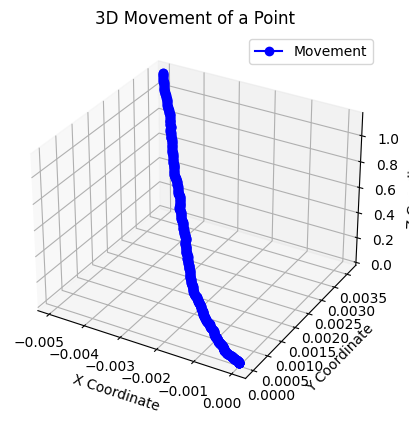

In [59]:
positions = np.reshape(np.concatenate(p_list), (int(len(p_list)), 3))
# Create a new figure for the 3D plot
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the movement of the point
ax.plot(positions[:,0], positions[:,1], positions[:,2], marker='o', linestyle='-', color='b', label='Movement')

# Set labels for each axis
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set a title
ax.set_title('3D Movement of a Point')

# Add a legend
ax.legend()

# Show the plot
plt.show()

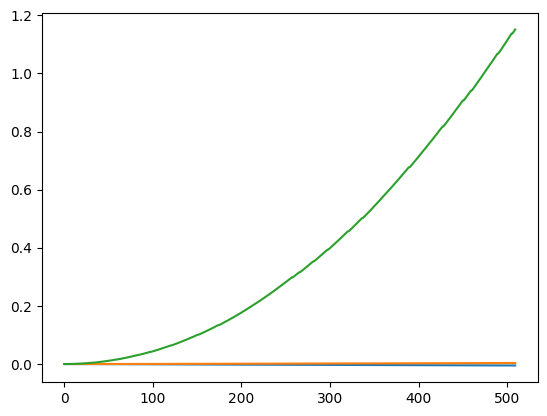

In [60]:
plt.plot(positions[:,0])
plt.plot(positions[:,1])
plt.plot(positions[:,2])
plt.show()